Successfully loaded Custom CNN
Model file for EfficientNet not found at ../final saved models/efficientnet_plant_disease_model.keras
Successfully loaded Inception
Successfully loaded MobileNet
Successfully loaded ResNet
Successfully loaded YOLOv8

Loaded test images shape : (4122, 224, 224, 3)
Loaded test labels shape : (4122, 15)

Evaluating Custom CNN...
-> Loss: 0.2873 | Acc: 0.9049 | Prec: 0.9205 | Recall: 0.9049 | F1: 0.9054 | Inference Time: 1.41 ms/img

Evaluating Inception...
-> Loss: 0.4389 | Acc: 0.8734 | Prec: 0.8739 | Recall: 0.8734 | F1: 0.8729 | Inference Time: 8.06 ms/img

Evaluating MobileNet...
-> Loss: 0.2159 | Acc: 0.9335 | Prec: 0.9327 | Recall: 0.9335 | F1: 0.9324 | Inference Time: 5.49 ms/img

Evaluating ResNet...
-> Loss: 0.7816 | Acc: 0.7504 | Prec: 0.7508 | Recall: 0.7504 | F1: 0.7388 | Inference Time: 24.76 ms/img

Evaluating YOLOv8...
-> Loss: 0.0553 | Acc: 0.9830 | Prec: 0.9833 | Recall: 0.9830 | F1: 0.9828 | Inference Time: 4.42 ms/img


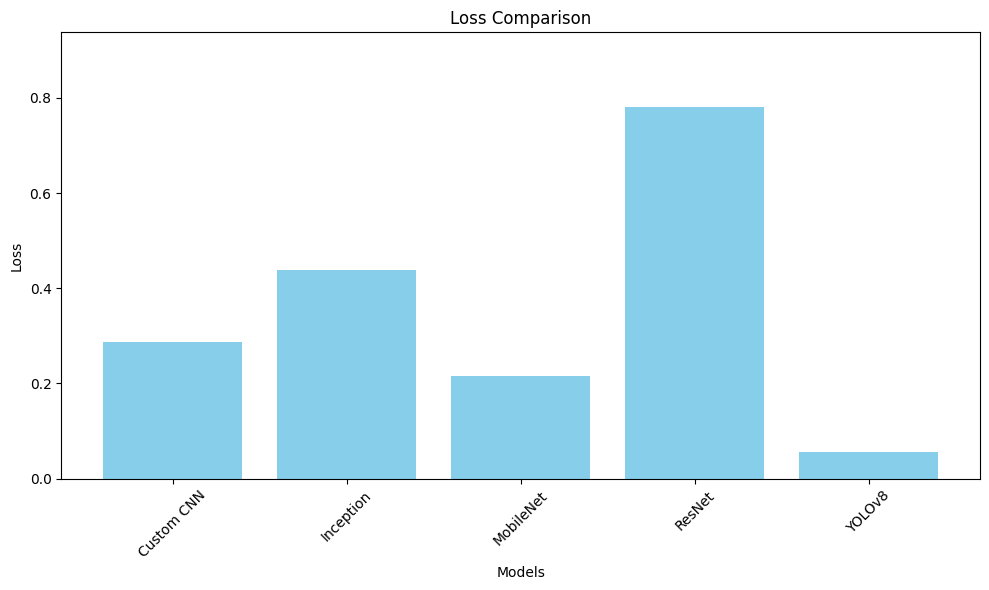

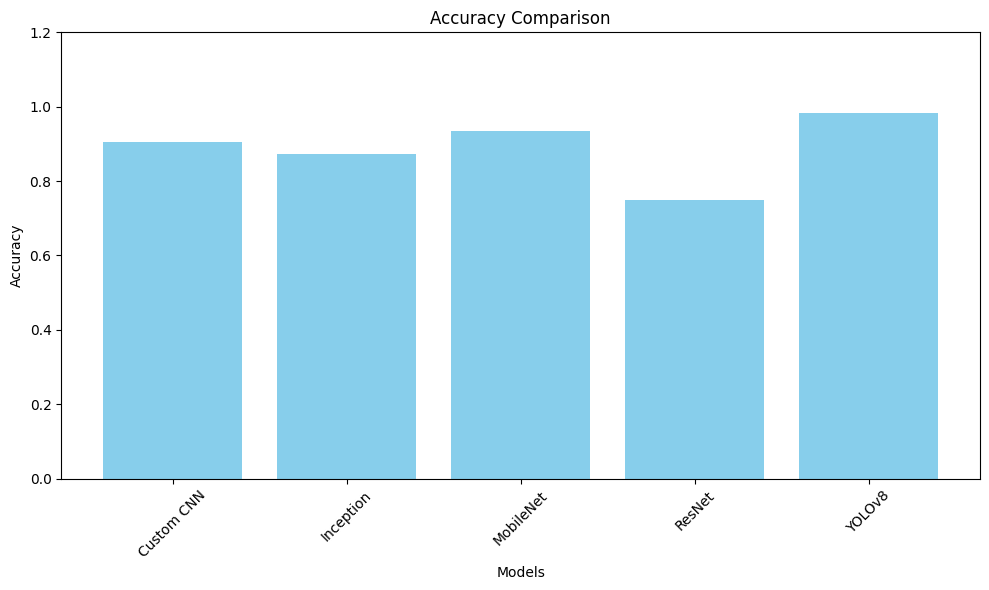

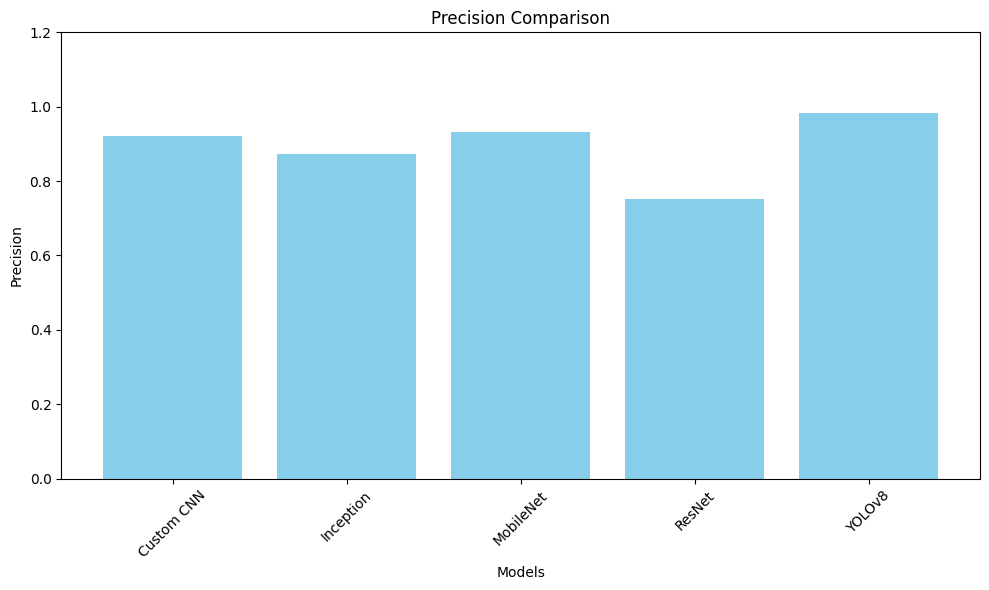

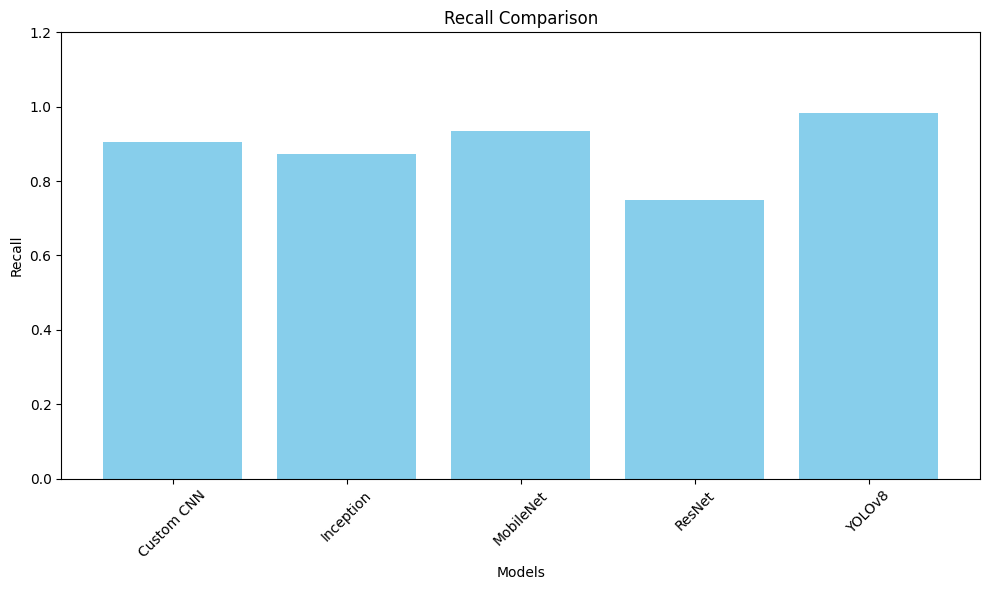

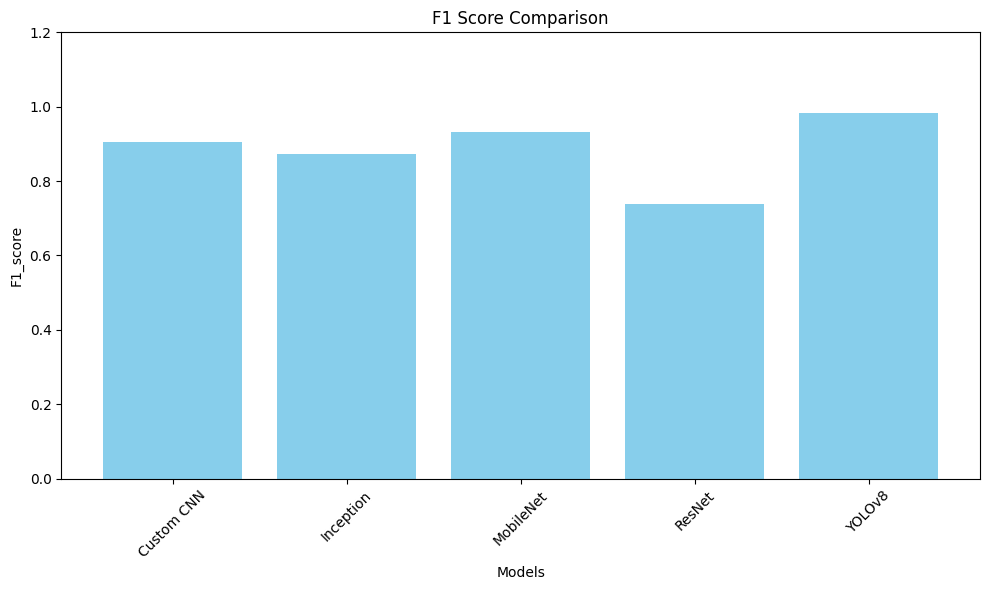

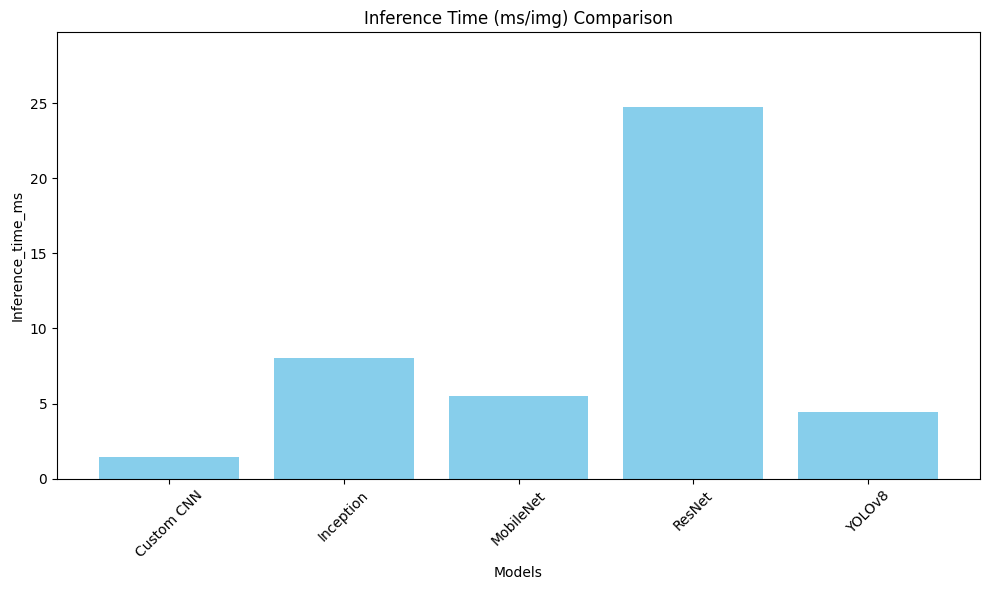

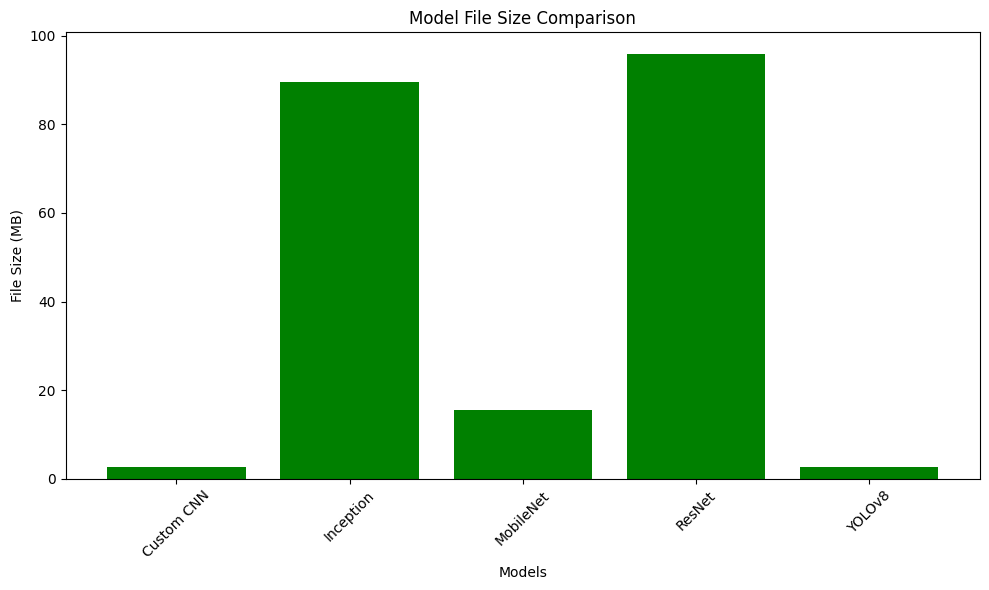

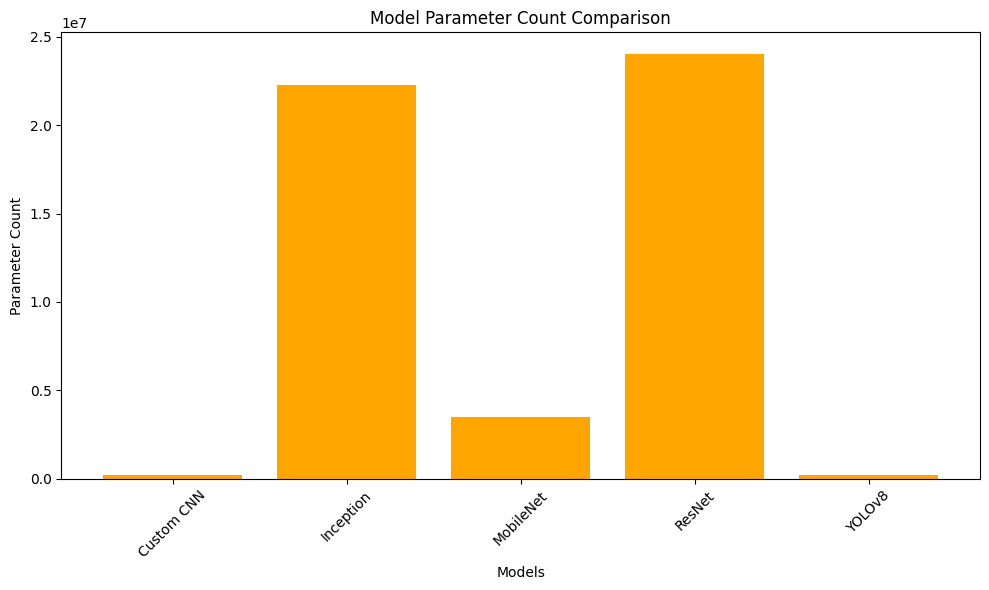

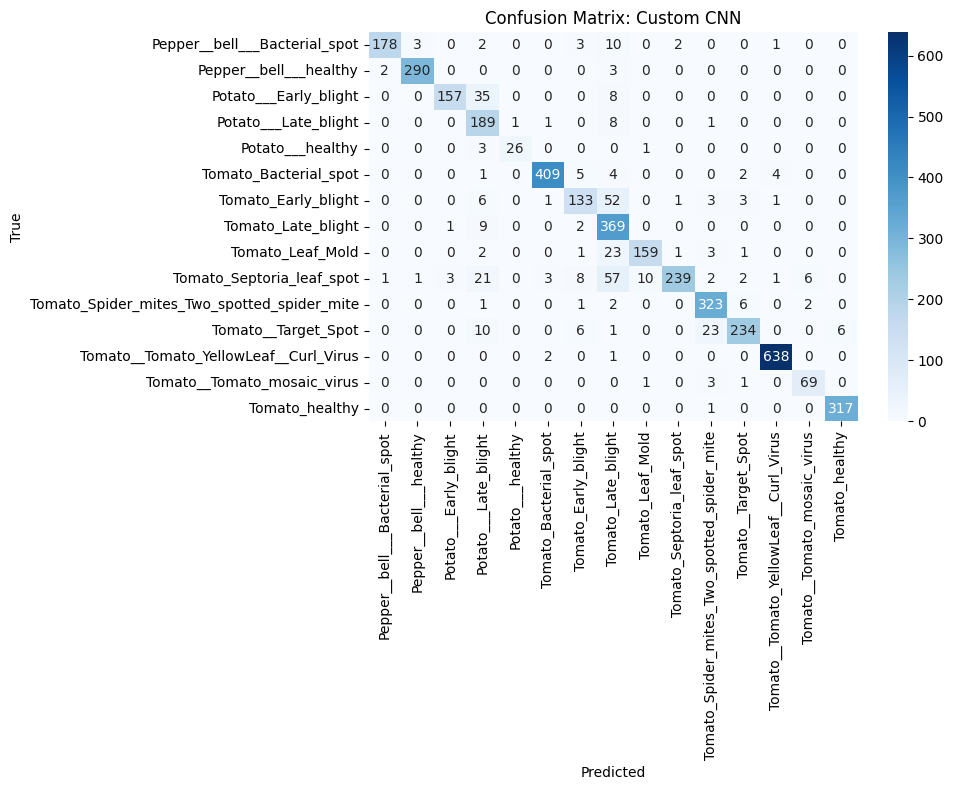

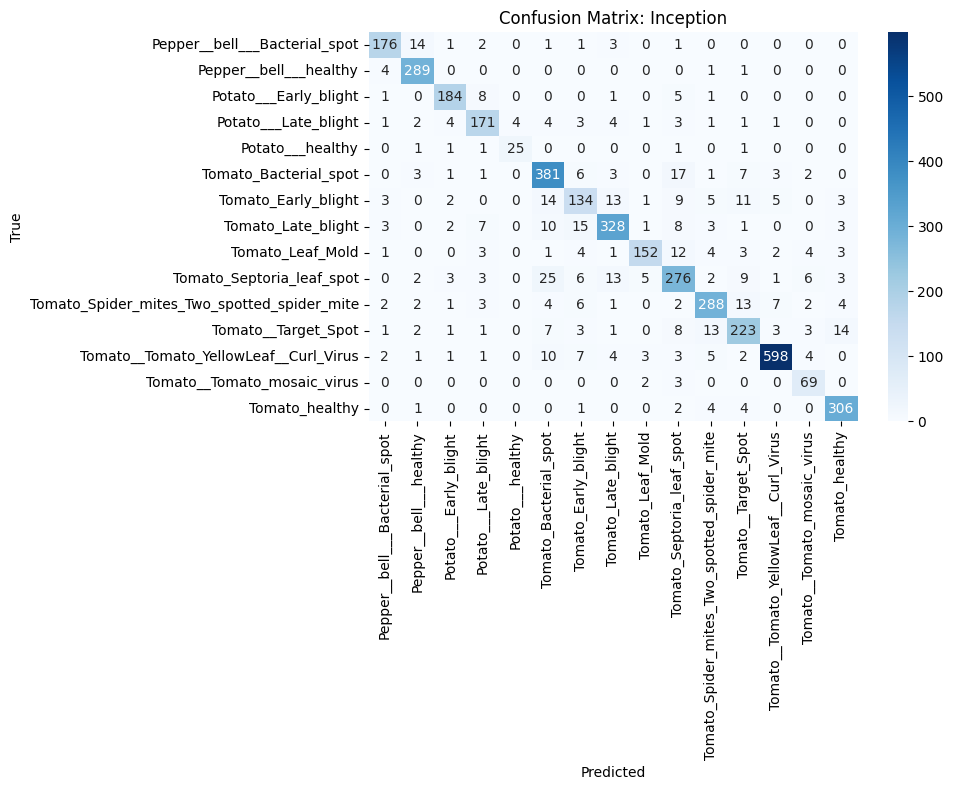

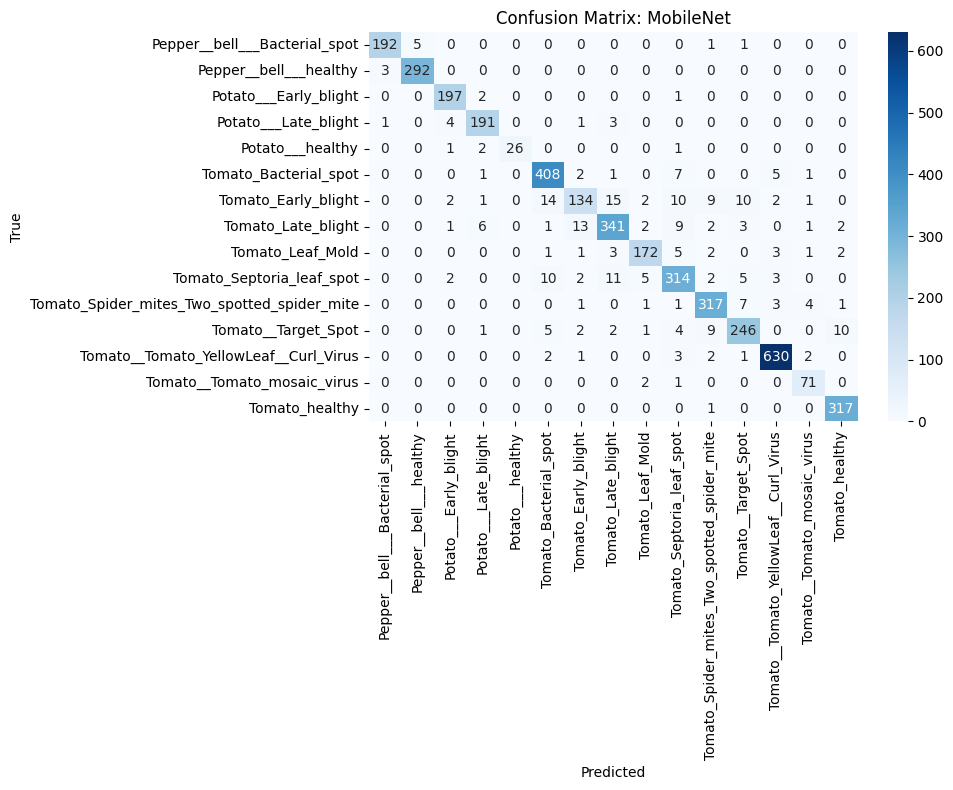

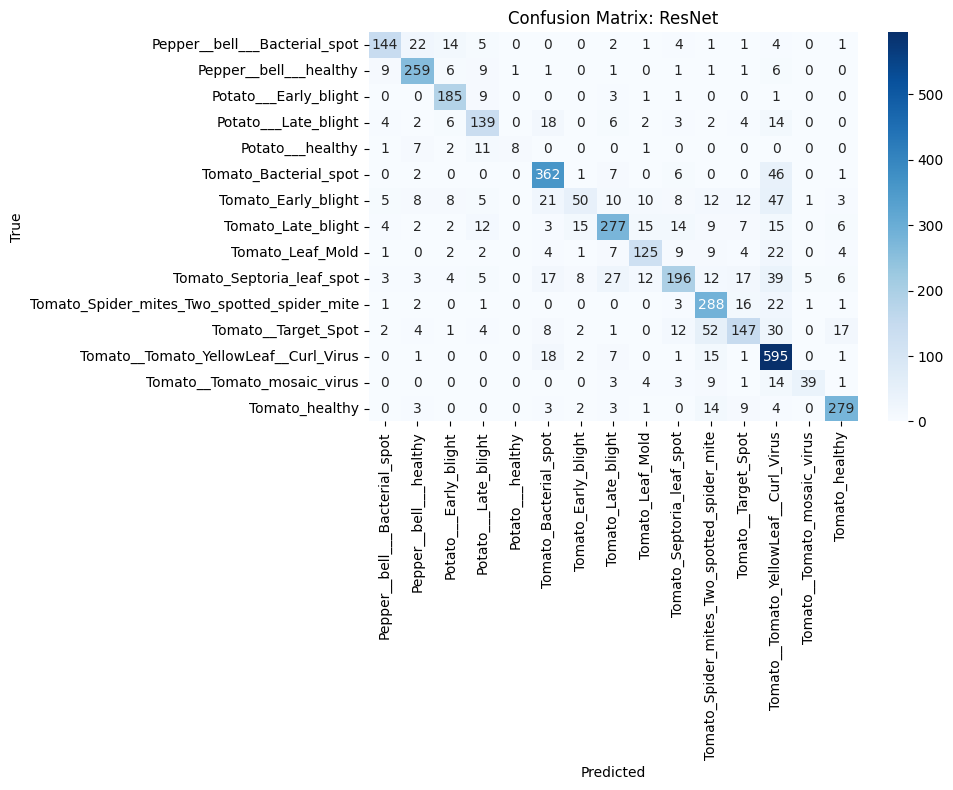

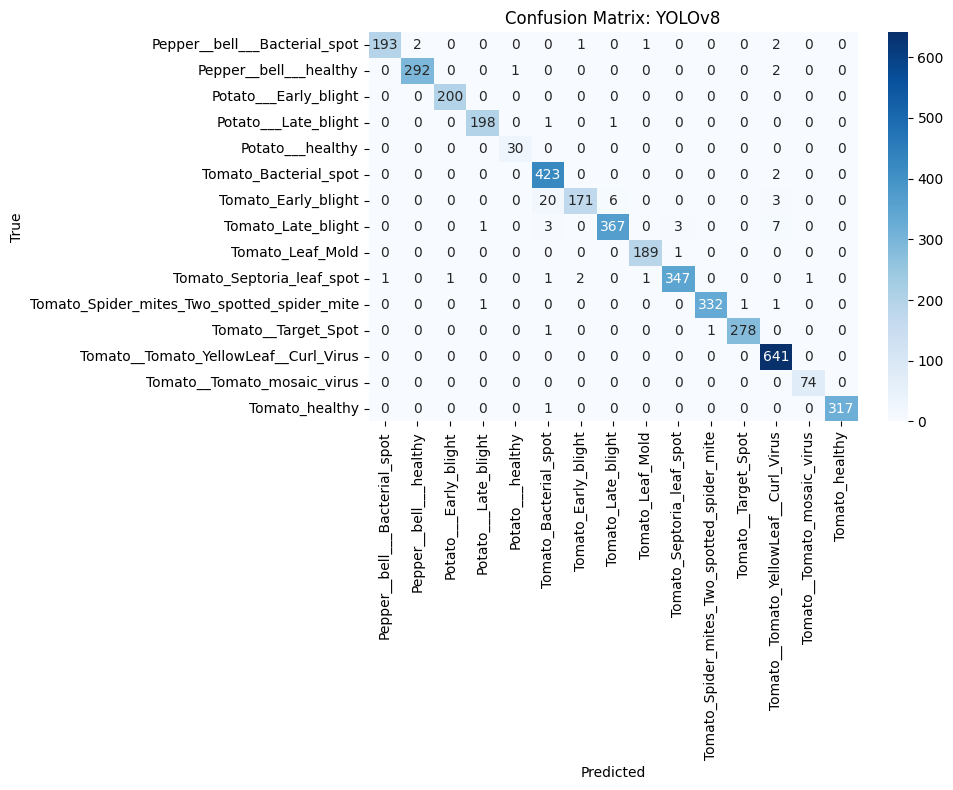


===== Custom CNN Classification Report =====
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.89      0.94       199
                     Pepper__bell___healthy       0.99      0.98      0.98       295
                      Potato___Early_blight       0.98      0.79      0.87       200
                       Potato___Late_blight       0.68      0.94      0.79       200
                           Potato___healthy       0.96      0.87      0.91        30
                      Tomato_Bacterial_spot       0.98      0.96      0.97       425
                        Tomato_Early_blight       0.84      0.67      0.74       200
                         Tomato_Late_blight       0.69      0.97      0.80       381
                           Tomato_Leaf_Mold       0.93      0.84      0.88       190
                  Tomato_Septoria_leaf_spot       0.98      0.68      0.80       354
Tomato_Spider_mite

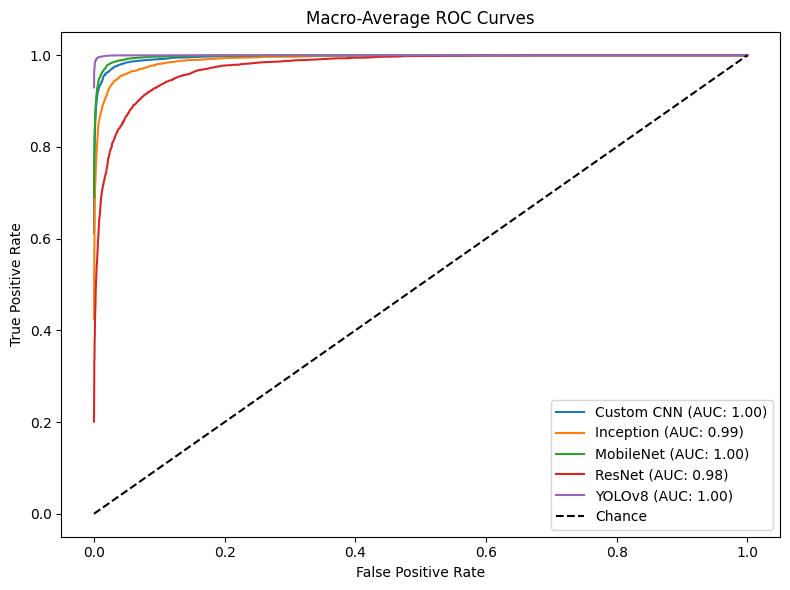

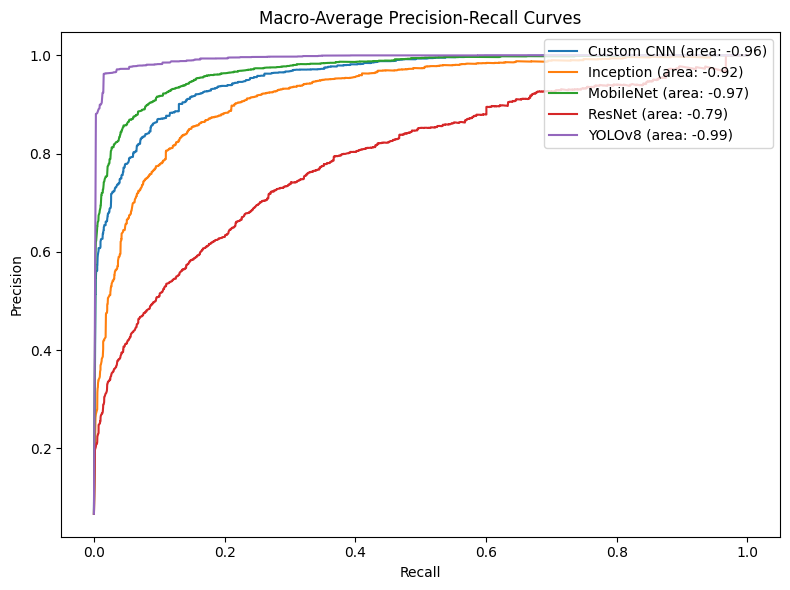


All evaluations and plots have completed successfully.


In [1]:
"""
Full Model Comparison Script with Additional Analysis
=====================================================

Features:
1. Load multiple .keras models
2. Load test images from directory subfolders
3. Evaluate performance (loss, acc, precision, recall, f1)
4. Plot bar charts for metrics
5. Plot confusion matrices & classification reports
6. Plot macro-average ROC curves
7. Plot macro-average Precision-Recall curves
8. Compare model sizes (MB) & parameter counts
9. Measure and compare inference time (ms/image)
10. (Optional) Plot confidence distributions for correct/incorrect predictions

Note:
- For real edge-device testing, measure inference times on the actual device.
"""

import os
import time
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)
from keras.utils import to_categorical

# ============================
# 1) SETUP AND CLASS DEFINITIONS
# ============================
classification_types = [
    'Pepper__bell___Bacterial_spot','Pepper__bell___healthy',
    'Potato___Early_blight','Potato___Late_blight','Potato___healthy',
    'Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight',
    'Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]
NUM_CLASSES = len(classification_types)

# Path to folder containing subfolders (one folder per class) for test images
test_dir = "../PlantVillageTest"  # Adjust to your path

# =========================
# 2) DEFINE MODEL FILE PATHS
# =========================
model_paths = {
    "Custom CNN":       "../final saved models/custom_plant_disease_model.keras",
    "EfficientNet":     "../final saved models/efficientnet_plant_disease_model.keras",
    "Inception":        "../final saved models/inceptionv3_plant_disease_model.keras",
    "MobileNet":        "../final saved models/mobilenet_plant_disease_model.keras",
    "ResNet":           "../final saved models/resnet_plant_disease_model.keras",
    "YOLOv8":           "../final saved models/yolov8_plant_disease_model.keras"
}

# ======================================
# 3) LOAD MODELS WITH ERROR HANDLING
# ======================================
models = {}
for name, path in model_paths.items():
    if os.path.exists(path):
        try:
            loaded_model = tf.keras.models.load_model(path)
            models[name] = loaded_model
            print(f"Successfully loaded {name}")
        except Exception as e:
            print(f"Error loading {name} from {path}: {e}")
    else:
        print(f"Model file for {name} not found at {path}")

# ================================
# 4) LOAD TEST DATA FROM FOLDER STRUCTURE
# ================================
DEFAULT_IMAGE_SIZE = (224, 224)  # Use a default. We'll re-resize for each model.
COLORS = 3

test_files = []
for disease_id, disease_name in enumerate(classification_types):
    disease_folder = os.path.join(test_dir, disease_name)
    if not os.path.isdir(disease_folder):
        print(f"Warning: Folder not found: {disease_folder}")
        continue
    for file_name in os.listdir(disease_folder):
        full_path = os.path.join(disease_folder, file_name)
        # Filter out non-image files if needed
        if not full_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        test_files.append((full_path, disease_id))

X_test_raw = np.zeros(
    (len(test_files), DEFAULT_IMAGE_SIZE[0], DEFAULT_IMAGE_SIZE[1], COLORS),
    dtype=np.float32
)
y_test_list = []

for i, (path, disease_id) in enumerate(test_files):
    img = cv2.imread(path)
    if img is not None:
        img_resized = cv2.resize(img, DEFAULT_IMAGE_SIZE, interpolation=cv2.INTER_AREA)
        img_resized = img_resized / 255.0  # normalize
        X_test_raw[i] = img_resized
    y_test_list.append(disease_id)

y_test_raw = to_categorical(y_test_list, num_classes=NUM_CLASSES)
print("\nLoaded test images shape :", X_test_raw.shape)
print("Loaded test labels shape :", y_test_raw.shape)

# =============================================
# 5) HELPER FUNCTION: RESIZE IMAGES PER MODEL
# =============================================
def resize_test_data_for_model(X_raw, model):
    """
    Resizes images from the default shape to the model's expected input shape.
    Assumes model.input_shape == (None, H, W, 3).
    If H or W is None, skip resizing (model might accept flexible shape).
    """
    input_shape = model.input_shape  # e.g., (None, 224, 224, 3)
    _, H, W, C = input_shape

    if (H is None) or (W is None):
        print(f"Warning: Model {model} has flexible input shape. Skipping resizing.")
        return X_raw

    X_resized = np.zeros((X_raw.shape[0], H, W, C), dtype=np.float32)
    for i in range(X_raw.shape[0]):
        X_resized[i] = cv2.resize(X_raw[i], (W, H), interpolation=cv2.INTER_AREA)
    return X_resized

# ===============================
# 6) EVALUATE MODELS AND COLLECT METRICS
# ===============================
def evaluate_models(models, X_raw, y_raw):
    """
    Evaluates each model on the test set (X_raw, y_raw).
    Returns a dict with:
      - loss
      - accuracy
      - precision (weighted)
      - recall (weighted)
      - f1_score (weighted)
      - confusion_matrix
      - classification_report
      - preds (for further analysis)
      - inference_time (ms/image) [approx. on local machine]
    """
    performance = {}
    y_true_int = np.argmax(y_raw, axis=1)  # integer labels for scikit-learn

    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")

        # 1) Resize images
        X_test = resize_test_data_for_model(X_raw, model)

        # 2) Measure inference time
        # We'll do a simple time measurement across the entire test set, then get average
        start_time = time.time()
        # Evaluate => loss & acc
        loss, acc = model.evaluate(X_test, y_raw, verbose=0)
        # Predict
        preds = model.predict(X_test, verbose=0)
        end_time = time.time()

        total_time = (end_time - start_time)
        # ms per image
        ms_per_image = (total_time / X_test.shape[0]) * 1000.0

        # 3) Compute additional metrics
        y_pred_int = np.argmax(preds, axis=1)

        precision = precision_score(y_true_int, y_pred_int, average='weighted', zero_division=0)
        recall    = recall_score(y_true_int, y_pred_int, average='weighted', zero_division=0)
        f1        = f1_score(y_true_int, y_pred_int, average='weighted', zero_division=0)

        # 4) Confusion matrix + classification report
        cm = confusion_matrix(y_true_int, y_pred_int)
        report = classification_report(y_true_int, y_pred_int, target_names=classification_types, zero_division=0)

        # 5) Store results
        performance[model_name] = {
            "loss": loss,
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "confusion_matrix": cm,
            "classification_report": report,
            "predictions": preds,   # shape: (num_samples, NUM_CLASSES)
            "inference_time_ms": ms_per_image
        }

        # Print summary
        print(f"-> Loss: {loss:.4f} | Acc: {acc:.4f} | Prec: {precision:.4f} | Recall: {recall:.4f} | "
              f"F1: {f1:.4f} | Inference Time: {ms_per_image:.2f} ms/img")

    return performance

model_performance = evaluate_models(models, X_test_raw, y_test_raw)

# =================================================
# 7) GATHER EXTRA MODEL STATS (SIZE, PARAM COUNT)
# =================================================
def get_file_size_in_mb(file_path):
    # Returns file size in MB
    file_bytes = os.path.getsize(file_path)
    return file_bytes / (1024 * 1024)

# We'll create dictionaries for model sizes and param counts
model_sizes_mb = {}
model_param_counts = {}

for model_name in models:
    path = model_paths[model_name]
    # 1) File size
    if os.path.exists(path):
        size_mb = get_file_size_in_mb(path)
    else:
        size_mb = 0
    model_sizes_mb[model_name] = size_mb

    # 2) Parameter count
    param_count = models[model_name].count_params()
    model_param_counts[model_name] = param_count

# =========================
# 8) PLOTTING AND VISUALIZATION
# =========================

# ------------------------
# 8.1 Bar Charts of Metrics
# ------------------------
def plot_bar_metrics(model_performance, metric, title=None, ylim=None):
    model_names = list(model_performance.keys())
    metric_values = [model_performance[m][metric] for m in model_names]

    plt.figure(figsize=(10,6))
    plt.bar(model_names, metric_values, color='skyblue')
    plt.xlabel("Models")
    plt.ylabel(metric.capitalize())
    plt.title(title if title else f"Model Comparison: {metric.capitalize()}")

    if ylim:
        plt.ylim(*ylim)
    else:
        if metric == "loss":
            y_max = max(metric_values) * 1.2
            plt.ylim([0, y_max])
        elif metric == "inference_time_ms":
            # Might vary widely
            y_max = max(metric_values) * 1.2
            plt.ylim([0, y_max])
        else:
            # Usually accuracy, precision, recall, f1 are in [0,1].
            plt.ylim([0, 1.2])

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot each core metric
plot_bar_metrics(model_performance, "loss",      title="Loss Comparison")
plot_bar_metrics(model_performance, "accuracy",  title="Accuracy Comparison")
plot_bar_metrics(model_performance, "precision", title="Precision Comparison")
plot_bar_metrics(model_performance, "recall",    title="Recall Comparison")
plot_bar_metrics(model_performance, "f1_score",  title="F1 Score Comparison")
plot_bar_metrics(model_performance, "inference_time_ms",  title="Inference Time (ms/img) Comparison")

# -----------------------------
# 8.2 Plot Model Size and Param Count
# -----------------------------
def plot_model_sizes(model_sizes_dict):
    model_names = list(model_sizes_dict.keys())
    sizes_mb = [model_sizes_dict[m] for m in model_names]

    plt.figure(figsize=(10,6))
    plt.bar(model_names, sizes_mb, color='green')
    plt.xlabel("Models")
    plt.ylabel("File Size (MB)")
    plt.title("Model File Size Comparison")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_param_counts(param_counts_dict):
    model_names = list(param_counts_dict.keys())
    param_counts = [param_counts_dict[m] for m in model_names]

    plt.figure(figsize=(10,6))
    plt.bar(model_names, param_counts, color='orange')
    plt.xlabel("Models")
    plt.ylabel("Parameter Count")
    plt.title("Model Parameter Count Comparison")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_model_sizes(model_sizes_mb)
plot_param_counts(model_param_counts)

# -----------------------------
# 8.3 Confusion Matrices
# -----------------------------
def plot_confusion_matrix(cm, class_names, model_name="Model"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

for model_name, metrics in model_performance.items():
    cm = metrics["confusion_matrix"]
    plot_confusion_matrix(cm, classification_types, model_name=model_name)

# -----------------------------
# 8.4 Classification Reports (Text)
# -----------------------------
for model_name, metrics in model_performance.items():
    print(f"\n===== {model_name} Classification Report =====")
    print(metrics["classification_report"])

# -----------------------------
# 8.5 Macro-Average ROC Curves
# -----------------------------
def plot_roc_curves(model_performance, X_raw, y_raw):
    """
    Plots macro-average ROC curve for each model in model_performance.
    """
    y_true = np.argmax(y_raw, axis=1)
    n_classes = y_raw.shape[1]

    plt.figure(figsize=(8,6))

    for model_name in model_performance.keys():
        model = models[model_name]
        X_test = resize_test_data_for_model(X_raw, model)
        y_score = model.predict(X_test, verbose=0)

        # Compute ROC/AUC for each class, then macro-average
        fpr_dict, tpr_dict, auc_dict = {}, {}, {}
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_raw[:, i], y_score[:, i])
            fpr_dict[i] = fpr
            tpr_dict[i] = tpr
            auc_dict[i] = auc(fpr, tpr)

        # Macro-average
        all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
        mean_tpr /= n_classes

        macro_auc = auc(all_fpr, mean_tpr)
        plt.plot(all_fpr, mean_tpr, label=f"{model_name} (AUC: {macro_auc:.2f})", linewidth=1.5)

    plt.plot([0,1],[0,1],'k--',label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Macro-Average ROC Curves")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Uncomment to plot ROC curves
plot_roc_curves(model_performance, X_test_raw, y_test_raw)

# -----------------------------
# 8.6 Macro-Average Precision-Recall Curves
# -----------------------------
def plot_pr_curves(model_performance, X_raw, y_raw):
    """
    Plots macro-average Precision-Recall curve for each model in model_performance.
    """
    y_true = np.argmax(y_raw, axis=1)
    n_classes = y_raw.shape[1]

    plt.figure(figsize=(8,6))

    for model_name in model_performance.keys():
        model = models[model_name]
        X_test = resize_test_data_for_model(X_raw, model)
        y_score = model.predict(X_test, verbose=0)

        # We'll compute one-vs-all PR, then do macro-average
        precision_dict, recall_dict, pr_auc_dict = {}, {}, {}
        for i in range(n_classes):
            # for each class i, create binary ground truth
            y_true_bin = (y_true == i).astype(int)
            precision_i, recall_i, _ = precision_recall_curve(y_true_bin, y_score[:, i])
            precision_dict[i] = precision_i
            recall_dict[i] = recall_i
            # Use area under the PR curve as an approximate metric
            # We can do numeric integration
            # approximate trapezoidal rule
            area = 0
            for idx in range(len(precision_i) - 1):
                area += (recall_i[idx+1] - recall_i[idx]) * (precision_i[idx+1] + precision_i[idx]) * 0.5
            pr_auc_dict[i] = area

        # Macro-average: carefully unify all recall points
        all_recall = np.unique(np.concatenate([recall_dict[i] for i in range(n_classes)]))
        mean_precision = np.zeros_like(all_recall)
        for i in range(n_classes):
            mean_precision += np.interp(all_recall[::-1], recall_dict[i][::-1], precision_dict[i][::-1])
        mean_precision /= n_classes
        # Reverse arrays because we interpolated in reverse
        all_recall = all_recall[::-1]
        mean_precision = mean_precision[::-1]

        # Approx area under the macro-average PR curve
        macro_pr_auc = 0
        for idx in range(len(all_recall) - 1):
            macro_pr_auc += (all_recall[idx+1] - all_recall[idx]) * (mean_precision[idx+1] + mean_precision[idx]) * 0.5

        plt.plot(all_recall, mean_precision, label=f"{model_name} (area: {macro_pr_auc:.2f})", linewidth=1.5)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Macro-Average Precision-Recall Curves")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Uncomment to plot PR curves
plot_pr_curves(model_performance, X_test_raw, y_test_raw)

# -----------------------------
# 8.7 (Optional) Confidence Distribution
# -----------------------------
def plot_confidence_distributions(model_performance, model_name):
    """
    Plot histograms of predicted probabilities (for correct vs incorrect predictions).
    This helps visualize how "confident" a model is when it's right vs. wrong.
    """
    preds = model_performance[model_name]["predictions"]
    y_true_int = np.argmax(y_test_raw, axis=1)
    y_pred_int = np.argmax(preds, axis=1)

    # Confidence = probability of the predicted class
    predicted_confidences = preds[np.arange(len(preds)), y_pred_int]

    # Separate correct from incorrect
    correct_mask = (y_true_int == y_pred_int)
    correct_confidences = predicted_confidences[correct_mask]
    incorrect_confidences = predicted_confidences[~correct_mask]

    plt.figure(figsize=(8,6))
    sns.histplot(correct_confidences, color='green', kde=True, label='Correct', bins=20)
    sns.histplot(incorrect_confidences, color='red', kde=True, label='Incorrect', bins=20)
    plt.xlabel("Predicted Class Probability")
    plt.ylabel("Count")
    plt.title(f"Confidence Distribution: {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage for one model:
# plot_confidence_distributions(model_performance, "YOLOv8-like")

# ============================
print("\nAll evaluations and plots have completed successfully.")
